<a href="https://www.kaggle.com/code/gamzebayir/telco-customer-churn?scriptVersionId=94144573" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv


In [2]:
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
df_=pd.read_csv('../input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv')


In [4]:
df=df_.copy()

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [6]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [7]:
df["TotalCharges"]=df["TotalCharges"].str.replace(' ', '0').astype(float)

In [8]:
df.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [9]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    """

    It gives the names of categorical, numerical and categorical but cardinal variables in the data set.
    Note: Categorical variables with numerical appearance are also included in categorical variables.

    Parameters
    ------
        dataframe: dataframe
                The dataframe from which variable names are to be retrieved
        cat_th: int, optional
                Class threshold value for numeric but categorical variables
        car_th: int, optinal
                Class threshold for categorical but cardinal variables

    Returns
    ------
        cat_cols: list
                Categorical variable list
        num_cols: list
                Numerical variable list
        cat_but_car: list
                Categorical view cardinal variable list

    Examples
    ------
        import seaborn as sns
        df = sns.load_dataset("iris")
        print(grab_col_names(df))


    Notes
    ------
        cat_cols + num_cols + cat_but_car = the total number of variables
        num_but_cat is inside cat_cols.
        The sum of 3 lists with return is equal to the total number of variables: cat_cols + num_cols + cat_but_car = number of variables

    """

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f"cat_cols: {len(cat_cols)}")
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')

    return cat_cols, num_cols, cat_but_car

In [10]:
cat_cols, num_cols, cat_but_car =grab_col_names(df)

Observations: 7043
Variables: 21
cat_cols: 17
num_cols: 3
cat_but_car: 1
num_but_cat: 1


In [11]:
print(f" cat_cols: {cat_cols}\n num_cols: {num_cols} \n cat_but_car: {cat_but_car}")
df[num_cols].describe().T

 cat_cols: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'Churn', 'SeniorCitizen']
 num_cols: ['tenure', 'MonthlyCharges', 'TotalCharges'] 
 cat_but_car: ['customerID']


,count,mean,std,min,25%,50%,75%,max
tenure,7043.0,32.371149,24.559481,0.00,9.00,29.00,55.00,72.00
MonthlyCharges,7043.0,64.761692,30.090047,18.25,35.50,70.35,89.85,118.75
TotalCharges,7043.0,2279.734304,2266.794470,0.00,398.55,1394.55,3786.60,8684.80


In [12]:
for i in num_cols:
    print(f"{i} :\n{df.groupby('Churn')[i].mean()}\n")

tenure :
Churn
No     37.569965
Yes    17.979133
Name: tenure, dtype: float64

MonthlyCharges :
Churn
No     61.265124
Yes    74.441332
Name: MonthlyCharges, dtype: float64

TotalCharges :
Churn
No     2549.911442
Yes    1531.796094
Name: TotalCharges, dtype: float64



In [13]:
def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))

    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show()

In [14]:
for col in cat_cols:
    cat_summary(df, col)

        gender     Ratio
Male      3555  50.47565
Female    3488  49.52435
     Partner     Ratio
No      3641  51.69672
Yes     3402  48.30328
     Dependents      Ratio
No         4933  70.041176
Yes        2110  29.958824
     PhoneService      Ratio
Yes          6361  90.316626
No            682   9.683374
                  MultipleLines      Ratio
No                         3390  48.132898
Yes                        2971  42.183729
No phone service            682   9.683374
             InternetService      Ratio
Fiber optic             3096  43.958540
DSL                     2421  34.374556
No                      1526  21.666903
                     OnlineSecurity      Ratio
No                             3498  49.666335
Yes                            2019  28.666761
No internet service            1526  21.666903
                     OnlineBackup      Ratio
No                           3088  43.844952
Yes                          2429  34.488144
No internet service          1526

In [15]:
def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        dataframe[numerical_col].hist(bins=50)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show()

    print("#####################################")

In [16]:
for col in num_cols:
    num_summary(df, col)

count    7043.000000
mean       32.371149
std        24.559481
min         0.000000
5%          1.000000
10%         2.000000
20%         6.000000
30%        12.000000
40%        20.000000
50%        29.000000
60%        40.000000
70%        50.000000
80%        60.000000
90%        69.000000
95%        72.000000
99%        72.000000
max        72.000000
Name: tenure, dtype: float64
#####################################
count    7043.000000
mean       64.761692
std        30.090047
min        18.250000
5%         19.650000
10%        20.050000
20%        25.050000
30%        45.850000
40%        58.830000
50%        70.350000
60%        79.100000
70%        85.500000
80%        94.250000
90%       102.600000
95%       107.400000
99%       114.729000
max       118.750000
Name: MonthlyCharges, dtype: float64
#####################################
count    7043.000000
mean     2279.734304
std      2266.794470
min         0.000000
5%         48.600000
10%        83.470000
20%       265.3200

In [17]:
def target_summary_with_cat(dataframe, target, categorical_col):
    print(pd.DataFrame({"TARGET_MEAN": dataframe.groupby(categorical_col)[target].mean()}), end="\n\n\n")

In [18]:
def label_encoder(dataframe, binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe

In [19]:
binary_cols = [col for col in df.columns if df[col].dtype not in [int, float]
               and df[col].nunique() == 2]

for col in binary_cols:
    label_encoder(df, col)

In [20]:
for col in cat_cols:
    target_summary_with_cat(df,"Churn",col)

        TARGET_MEAN
gender             
0          0.269209
1          0.261603


         TARGET_MEAN
Partner             
0           0.329580
1           0.196649


            TARGET_MEAN
Dependents             
0              0.312791
1              0.154502


              TARGET_MEAN
PhoneService             
0                0.249267
1                0.267096


                  TARGET_MEAN
MultipleLines                
No                   0.250442
No phone service     0.249267
Yes                  0.286099


                 TARGET_MEAN
InternetService             
DSL                 0.189591
Fiber optic         0.418928
No                  0.074050


                     TARGET_MEAN
OnlineSecurity                  
No                      0.417667
No internet service     0.074050
Yes                     0.146112


                     TARGET_MEAN
OnlineBackup                    
No                      0.399288
No internet service     0.074050
Yes                     0.2153

In [21]:
def high_correlated_cols(dataframe, plot=False, corr_th=0.70):
    corr = dataframe.corr()
    cor_matrix = corr.abs()
    upper_triangle_matrix = cor_matrix.where(np.triu(np.ones(cor_matrix.shape), k=1).astype(np.bool))
    drop_list = [col for col in upper_triangle_matrix.columns if any(upper_triangle_matrix[col] > corr_th)]
    if plot:
        import seaborn as sns
        import matplotlib.pyplot as plt
        sns.set(rc={'figure.figsize': (15, 15)})
        sns.heatmap(corr, cmap="RdBu")
        plt.show()
    return drop_list

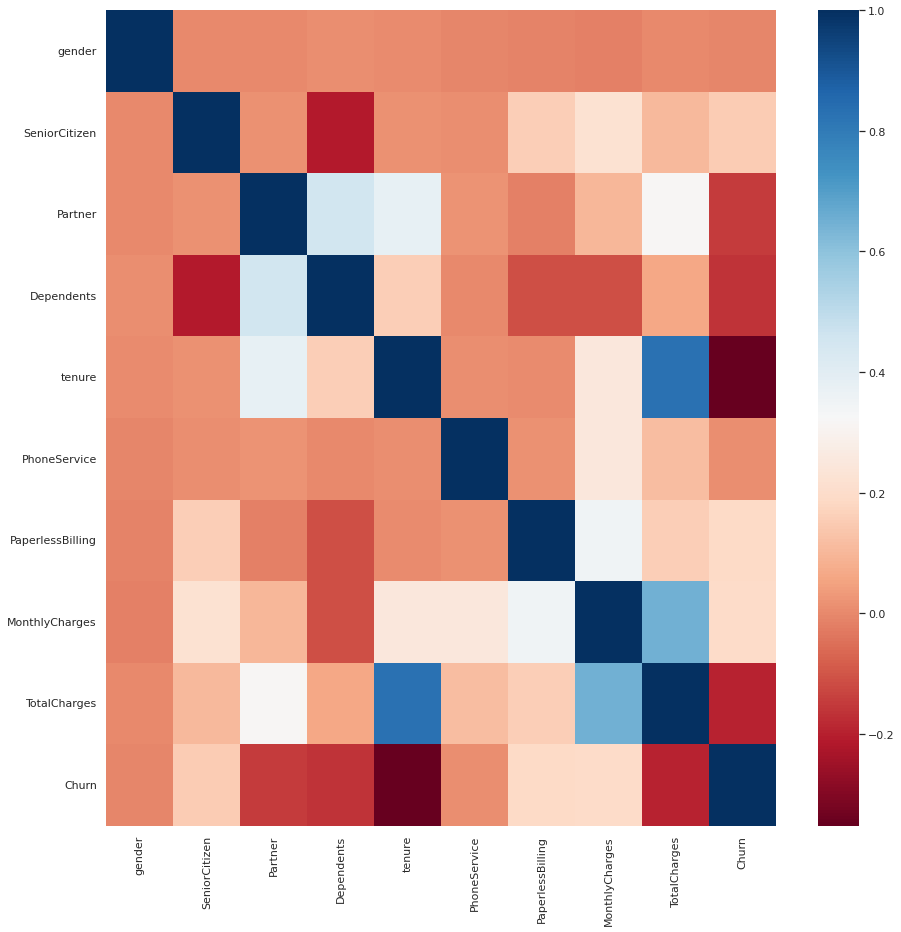

['TotalCharges']

In [22]:
high_correlated_cols(df, plot=True)

In [23]:
def outlier_thresholds(dataframe, col_name, q1=0.05, q3=0.95):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [24]:
for i in num_cols:
    low, up = outlier_thresholds(df, i)
    if ((df[i] < low) | (df[i] > up)).any():
        print(f"\nIndices: {df[(df[i] < low) | (df[i] > up)].index}\n")
        print(df[(df[i] < low) | (df[i] > up)].head())
        replace_with_thresholds(df, i)

In [25]:
def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]

    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n")

    if na_name:
        return na_columns

In [26]:
na_cols=missing_values_table(df, True)

Empty DataFrame
Columns: [n_miss, ratio]
Index: []


In [27]:
def apply_values_with_null(df, column):
    df[column] = df[column].apply(lambda x: np.nan if x == 0 else x)

In [28]:
columns=["TotalCharges"]
for column in columns:
    apply_values_with_null(df,column)

In [29]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 7043
Variables: 21
cat_cols: 17
num_cols: 3
cat_but_car: 1
num_but_cat: 7


In [30]:
num_cols = [col for col in num_cols if "customerID" not in col]

In [31]:
dff = pd.get_dummies(df[cat_cols + num_cols], drop_first=True)

In [32]:
# değişkenlerin standartlatırılması
scaler = MinMaxScaler()
df = pd.DataFrame(scaler.fit_transform(dff), columns=dff.columns)
df.head()

,gender,SeniorCitizen,Partner,Dependents,PhoneService,PaperlessBilling,Churn,tenure,MonthlyCharges,TotalCharges,...,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.013889,0.115423,0.001275,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.472222,0.385075,0.215867,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.027778,0.354229,0.010310,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.625000,0.239303,0.210241,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.027778,0.521891,0.015330,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [33]:
# knn'in uygulanması.
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=5)
df = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)
df.head()
df = pd.DataFrame(scaler.inverse_transform(df), columns=df.columns)

In [34]:
#feature_extract
df["Charges_Rate"]=df["TotalCharges"]/df["MonthlyCharges"]
df["TotalCharges*tenure"]=df["TotalCharges"]*df["tenure"]
df["DiffAmount"]=df["TotalCharges"]-df["MonthlyCharges"]*df["tenure"]
df["Sale"]=df["DiffAmount"].apply(lambda x:-x if x<0 else 0)
df["DiffAmount"]=df["DiffAmount"].apply(lambda x:x if x>0 else 0)
df["tenure/TotalCharges"]=df["tenure"]/df["TotalCharges"]
df["other_dependents"]=df["Dependents"]-df["Partner"]



In [35]:
def MM_Scaler(df,col):
    mms = MinMaxScaler()
    df[f"{col}_scaler"] = mms.fit_transform(df[[col]])

In [36]:
for column in num_cols:
    MM_Scaler(df,col)

In [37]:
def one_hot_encoder(dataframe, categorical_cols, drop_first=True):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

In [38]:
ohe_cols = [col for col in df.columns if 10 >= df[col].nunique() > 2]
one_hot_encoder(df, ohe_cols).head()

,gender,SeniorCitizen,Partner,Dependents,PhoneService,PaperlessBilling,Churn,tenure,MonthlyCharges,TotalCharges,...,PaymentMethod_Electronic check,PaymentMethod_Mailed check,Charges_Rate,TotalCharges*tenure,DiffAmount,Sale,tenure/TotalCharges,SeniorCitizen_scaler,other_dependents_0.0,other_dependents_1.0
0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,29.85,29.85,...,1.0,0.0,1.000000,29.85,0.00,0.00,0.033501,0.0,0,0
1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,34.0,56.95,1889.50,...,0.0,1.0,33.178227,64243.00,0.00,46.80,0.017994,0.0,1,0
2,1.0,0.0,0.0,0.0,1.0,1.0,1.0,2.0,53.85,108.15,...,0.0,1.0,2.008357,216.30,0.45,0.00,0.018493,0.0,1,0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,45.0,42.30,1840.75,...,0.0,0.0,43.516548,82833.75,0.00,62.75,0.024447,0.0,1,0
4,0.0,0.0,0.0,0.0,1.0,1.0,1.0,2.0,70.70,151.65,...,1.0,0.0,2.144979,303.30,10.25,0.00,0.013188,0.0,1,0


In [39]:
y = df["Churn"]
X = df.drop(["Churn"], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=17)


rf_model = RandomForestClassifier(random_state=46).fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
accuracy_score(y_pred, y_test)

0.7908187411263606